In [13]:
# Standard imports
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from math import sqrt

# Modifying and splitting the data
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# XGboost model
import xgboost as xgb

# Model selection tools
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

# Saving models
from sklearn.externals import joblib

# Error metrics
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
def parser(x):
    return datetime.strptime(x, '%d-%b-%Y')

def get_data(path, date):
    data = pd.read_csv(path , header=0, parse_dates=[date], index_col=date, squeeze=True, date_parser=parser)
    return data

In [15]:
look_back = 5
x = get_data('../ml-project-data/NIFTY-50/2014.csv', 0)
y = x.loc[: , "High":"Low"].mean(axis=1)
        
x_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    x_lag['t-'+str(i)] = y.shift(i)

x = x_lag

x = x.iloc[look_back:]
y = y.iloc[look_back:]

In [16]:
act_data = get_data('../ml-project-data/NIFTY-50/2015.csv', 0)
act = act_data.loc[: , "High":"Low"].mean(axis=1)
act = act[:int(len(act)/4)]
act_y = act
act = pd.concat([y[-5:], act])

act_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    act_lag['t-'+str(i)] = act.shift(i)

act = act_lag[look_back:]

In [5]:
# setup regressor
xgb_model = xgb.XGBRegressor()

# perform a grid search
tweaked_model = GridSearchCV(
    xgb_model,
    {
        'max_depth': range(1, 11, 1),
        'n_estimators': range(20, 120, 1),
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    cv=10,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

tweaked_model.fit(x, y)

# summarize results
print("Best: %f using %s" % (tweaked_model.best_score_, tweaked_model.best_params_))

Fitting 10 folds for each of 5000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1379 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 4064 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 5117 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 7817 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 13532 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 17024 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 19574 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 26078 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 29651 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 36092 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 40268 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 47150 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 49985 o

Best: -15788.634751 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 74}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [6]:
pred = tweaked_model.predict(act)

In [7]:
pred

array([8267.853 , 8267.853 , 8383.983 , 8396.945 , 8188.4976, 8085.4077,
       8192.809 , 8235.469 , 8259.948 , 8268.492 , 8267.853 , 8469.92  ,
       8471.1455, 8513.26  , 8519.748 , 8532.7   , 8530.709 , 8480.185 ,
       8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 ,
       8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 , 8488.196 ,
       8488.196 , 8480.185 , 8480.185 , 8464.124 , 8464.124 , 8464.124 ,
       8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 ,
       8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 ,
       8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 ,
       8464.124 , 8464.124 , 8464.124 , 8464.124 , 8464.124 , 8352.92  ,
       8315.6045, 8461.176 ], dtype=float32)

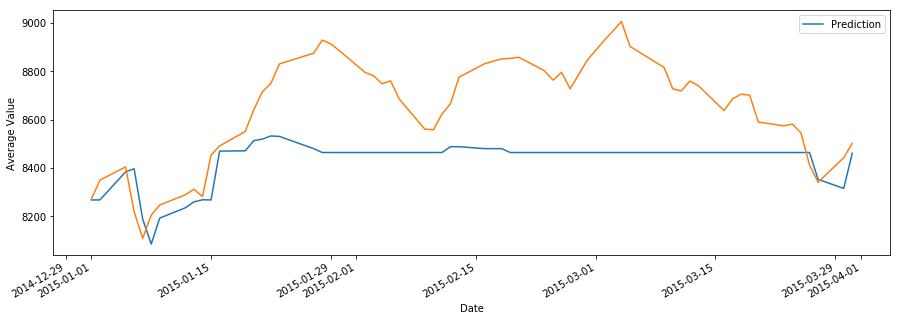

In [8]:
preds = pd.DataFrame(np.array(pred),index = act.index,columns=['Prediction'])
preds.plot(figsize=(15,5), label="Prediction")
act_y.plot(label="Actual")
plt.ylabel("Average Value")
plt.show()

In [9]:
rms = sqrt(mean_squared_error(act_y, pred))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((act_y - pred) / act_y)) * 100
print('MAPE: ' + str(mape))

RMSE: 269.0167834476766
MAPE: 2.607188270595439


In [17]:
tcs_x = get_data('../ml-project-data/TCS/01-01-2014-TO-31-12-2014TCSEQN.csv', 2)['Average Price']
tcs_y = tcs_x
        
tcs_x_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)

tcs_x = tcs_x_lag

tcs_x = tcs_x.iloc[look_back:]
tcs_y = tcs_y.iloc[look_back:]

In [18]:
tcs_act = get_data('../ml-project-data/TCS/01-01-2015-TO-31-12-2015TCSEQN.csv', 2)['Average Price']
tcs_act = tcs_act[:int(len(tcs_act)/4)]
tcs_act_y = tcs_act
tcs_act = pd.concat([tcs_y[-5:], tcs_act])

tcs_act_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

tcs_act = tcs_act_lag[look_back:]

In [19]:
tweaked_model.fit(tcs_x, tcs_y)

# summarize results
print("Best: %f using %s" % (tweaked_model.best_score_, tweaked_model.best_params_))

Fitting 10 folds for each of 5000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 5497 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 7617 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 9417 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 11617 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 14217 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 17217 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 20617 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 24417 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 28617 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 35573 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 39661 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 47607 tasks      | elapsed:  8.7min


Best: -1878.568726 using {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 61}


[Parallel(n_jobs=-1)]: Done 50000 out of 50000 | elapsed:  9.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
tcs_pred = tweaked_model.predict(tcs_act)

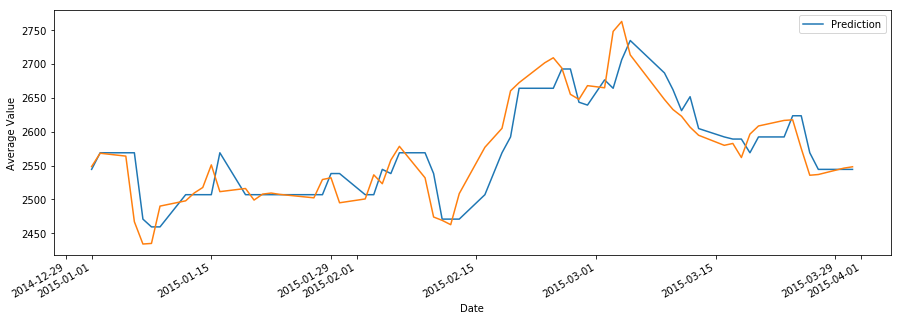

In [21]:
tcs_preds = pd.DataFrame(np.array(tcs_pred),index = act.index,columns=['Prediction'])
tcs_preds.plot(figsize=(15,5), label="Prediction")
tcs_act_y.plot(label="Actual")
plt.ylabel("Average Value")
plt.show()

In [22]:
rms = sqrt(mean_squared_error(tcs_act_y, tcs_pred))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((tcs_act_y - tcs_pred) / tcs_act_y)) * 100
print('MAPE: ' + str(mape))

RMSE: 33.222225859865105
MAPE: 0.9496008042241748


In [23]:
tcs_x['nifty'] = y
tcs_act['nifty'] = preds

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
tweaked_model.fit(tcs_x, tcs_y)

# summarize results
print("Best: %f using %s" % (tweaked_model.best_score_, tweaked_model.best_params_))

Fitting 10 folds for each of 5000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3020 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 5540 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 7640 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 10367 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 16051 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 19097 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 24491 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 27788 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 32150 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 37541 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 43523 tasks      | elapsed:  7.2min


Best: -1953.044289 using {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 38}


[Parallel(n_jobs=-1)]: Done 50000 out of 50000 | elapsed:  8.6min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
tcs_pred = tweaked_model.predict(tcs_act)

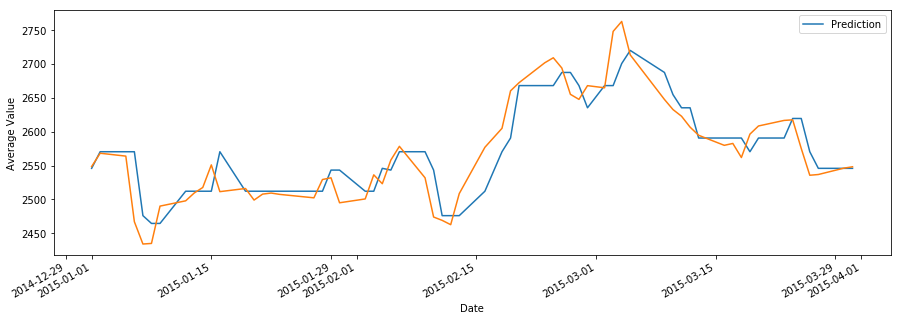

In [26]:
tcs_preds = pd.DataFrame(np.array(tcs_pred),index = act.index,columns=['Prediction'])
tcs_preds.plot(figsize=(15,5), label="Prediction")
tcs_act_y.plot(label="Actual")
plt.ylabel("Average Value")
plt.show()

In [27]:
rms = sqrt(mean_squared_error(tcs_act_y, tcs_pred))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((tcs_act_y - tcs_pred) / tcs_act_y)) * 100
print('MAPE: ' + str(mape))

RMSE: 32.77419019537697
MAPE: 0.9400049828651625
